In [ ]:
#skip this block is already installed

!pip install xgboost
!pip install lightgbm
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [1]:
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

from sklearn.model_selection import LeaveOneOut

from matplotlib import pyplot
from xgboost import plot_importance



color = sns.color_palette()

sys.path.insert(0,"/Users/fellipeferreira/OneDrive/CIT - Master Data Science/Semester 3/project/final-project-datascience-mtu/code/")  # path contains python_file.py
import utils
from utils import get_name_from_value
from utils import Target

In [2]:
print(Target(0).name)
print(Target(1).name)
get_name_from_value("1.0")

CONTROL
PATIENT


'PATIENT'

In [3]:
#PATH_TO_FILE = "../../psykose/schizophrenia-features.csv"

#my baseline features
PATH_TO_FILE = "../baseline_time_period.csv"

_PARAMS_LORGREG = {
    "penalty": "l2", "C": 1.0, "class_weight": "balanced",
    "random_state": 2018, "solver": "liblinear", "n_jobs": 1
}

_PARAMS_RFC = {
    "n_estimators": 10,
    "max_features": "auto", "max_depth": None,
    "min_samples_split": 2, "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_leaf_nodes": None, "bootstrap": True,
    "oob_score": False, "n_jobs": -1, "random_state": 2018,
    "class_weight": "balanced"
}

_PARAMS_DTC = {
    
    "max_features": "auto", "max_depth": None,
    "min_samples_split": 2, "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_leaf_nodes": None, 
     "random_state": 2018,
    "class_weight": "balanced"
    
}

_PARAMS_XGB = {
    "nthread":16, "learning_rate": 0.3, "gamma": 0, "max_depth": 6, "verbosity": 0,
    "min_child_weight": 1, "max_delta_step": 0, "subsample": 1.0, "colsample_bytree": 1.0,
    "objective":"binary:logistic", "num_class":1, "eval_metric":"logloss", "seed":2018,
}

_PARAMS_LIGHTGB = {
    "task": "train", "num_class":1, "boosting": "gbdt", "verbosity": -1,
    "objective": "binary", "metric": "binary_logloss", "metric_freq":50, "is_training_metric":False,
    "max_depth":4, "num_leaves": 31, "learning_rate": 0.01, "feature_fraction": 1.0, "bagging_fraction": 1.0,
    "bagging_freq": 0, "bagging_seed": 2018, "num_threads":16
}

# Data Frame to collect all results of the classifiers
df_result = pd.DataFrame()
df_feature_importance = pd.DataFrame()
df_leave_one_out = pd.DataFrame()

In [4]:
data = pd.read_csv(PATH_TO_FILE)

dataX = data.copy().drop(["class", "class_str", "userid"], axis=1)
dataY = data["class"].copy()

scaler = pp.StandardScaler(copy=True)

dataX.loc[:, dataX.columns] = scaler.fit_transform(dataX[dataX.columns])


testset_size = 0.5

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    dataX,
    dataY,
    test_size=testset_size,
    random_state=2019,
    stratify=dataY
)

In [5]:
def plot_prc_curve(y_preds, y_trues, title=None):
    
    precision, recall, _ = metrics.precision_recall_curve(
        y_trues,
        y_preds
    )

    average_precision = metrics.average_precision_score(
        y_trues,
        y_preds
    )

    print("Average Precision = %.2f" % average_precision)
    
    plt.step(recall, precision, color="k", alpha=0.7, where="post")
    plt.fill_between(recall, precision, step="post", alpha=0.3, color="k")

    if title is None:
        title = "PRC: Average Precision = %.2f" % average_precision

    plt.title(title)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.show()
    
    return average_precision

def plot_roc_curve(y_preds, y_trues, title=None):
    
    fpr, tpr, _ = metrics.roc_curve(y_trues, y_preds)

    auc_roc = metrics.auc(fpr, tpr)

    print("AUCROC = %.2f" % auc_roc)

    if title is None:
        title = "AUCROC = %.2f" % auc_roc

    plt.title(title)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    
    plt.plot(fpr, tpr, color="r", lw=2, label="ROC curve")
    plt.plot([0, 1], [0, 1], color="k", lw=2, linestyle="--")

    plt.show()
    
    return auc_roc


def model_predict_k_fold( train_func, pred_func, model=None, n_splits=10, shuffle=True, random_state=2018 ):
     
    y_preds = []
    y_trues = []

    k_fold = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    for train_index, fold_index in k_fold.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):
        
        x_fold_train, x_fold_test = X_TRAIN.iloc[train_index, :], X_TRAIN.iloc[fold_index, :]
        y_fold_train, y_fold_test = Y_TRAIN.iloc[train_index], Y_TRAIN.iloc[fold_index]

        model = train_func( model, x_fold_train, y_fold_train, x_fold_test, y_fold_test )
        y_pred = pred_func( model, x_fold_test )

        y_preds.extend( list(y_pred) )
        y_trues.extend( list(y_fold_test) )

    return model, np.array(y_preds), np.array(y_trues)


def leave_one_out(train_func, pred_func, model=None):
    y_preds = []
    y_trues = []

    loo = LeaveOneOut()

    for train_index, fold_index in loo.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):
        x_fold_train, x_fold_test = X_TRAIN.iloc[train_index, :], X_TRAIN.iloc[fold_index, :]
        y_fold_train, y_fold_test = Y_TRAIN.iloc[train_index], Y_TRAIN.iloc[fold_index]

        model = train_func(model, x_fold_train, y_fold_train, x_fold_test, y_fold_test)
        y_pred = pred_func(model, x_fold_test)

        y_preds.extend(list(y_pred))
        y_trues.extend(list(y_fold_test))

    return model, np.array(y_preds), np.array(y_trues)





# Logistic Regression

              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90       201
         1.0       0.85      0.89      0.87       142

    accuracy                           0.89       343
   macro avg       0.88      0.89      0.89       343
weighted avg       0.89      0.89      0.89       343

CONTROL
PATIENT
macro avg
weighted avg
Average Precision = 0.92


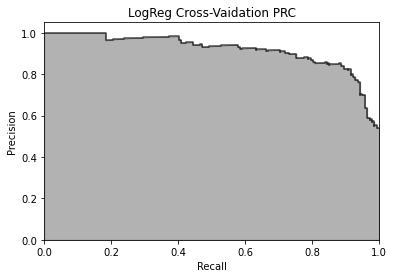

AUCROC = 0.94


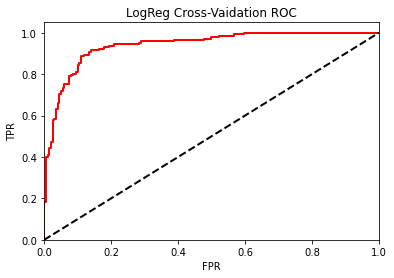

Average Precision = 0.89


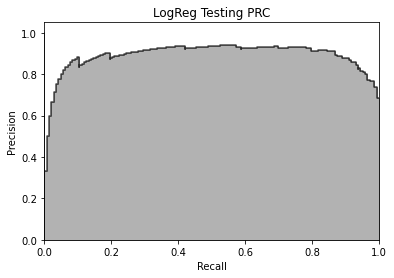

AUCROC = 0.96


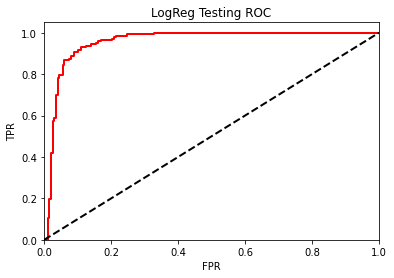

Feature: 0, Score: 0.34034
Feature: 1, Score: -0.81355
Feature: 2, Score: 0.15053
Feature: 3, Score: 0.10871
Feature: 4, Score: 0.04652
Feature: 5, Score: -0.00710
Feature: 6, Score: -0.65080
Feature: 7, Score: -0.05951
Feature: 8, Score: 0.23755
Feature: 9, Score: -0.29493
Feature: 10, Score: -0.23491
Feature: 11, Score: 0.51222
Feature: 12, Score: 0.10744
Feature: 13, Score: 0.43747
Feature: 14, Score: 0.99155
Feature: 15, Score: 0.10477
Feature: 16, Score: -0.13873
Feature: 17, Score: -0.06873
Feature: 18, Score: 0.41367
Feature: 19, Score: -1.59299
Feature: 20, Score: 1.53608
Feature: 21, Score: 1.31986
Feature: 22, Score: -0.81069
Feature: 23, Score: 0.72263
Feature: 24, Score: 0.45624
Feature: 25, Score: 0.67316
Feature: 26, Score: -0.67802


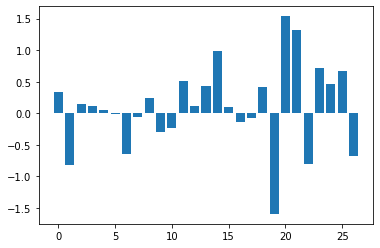

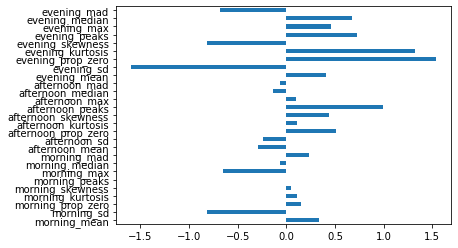

In [8]:
def logreg_train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model

def logreg_pred_func(model, data):
    return model.predict_proba(data)[:, 1]

logreg = LogisticRegression( **_PARAMS_LORGREG )

logreg, logreg_y_preds, logreg_y_trues = model_predict_k_fold( logreg_train_func, logreg_pred_func, logreg )
logreg_test_preds = logreg_pred_func( logreg, X_TEST )


#Leave one out
logreg_loo = LogisticRegression(**_PARAMS_LORGREG)
logreg_loo, logreg_y_preds_loo, logreg_y_trues_loo = leave_one_out( logreg_train_func, logreg_pred_func, logreg_loo )

print(classification_report(logreg_y_trues_loo, logreg_y_preds_loo.round()))
dict_report = classification_report(logreg_y_trues_loo, logreg_y_preds_loo.round(), output_dict=True)
for key, value in dict_report.items():
    row_loo = {"Classifier": "Logistic Regression" }
    if isinstance(value, dict):
        print(get_name_from_value(key))
        row_loo["Class"] = get_name_from_value(key)
        row_loo.update(value)

        #collect the result for leave one out
        df_leave_one_out = df_leave_one_out.append(row_loo, ignore_index=True )





#precision-recall curves (PRC)
#Receiver-operator curves (ROC)
average_precision = plot_prc_curve( logreg_y_preds, logreg_y_trues, "LogReg Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( logreg_y_preds, logreg_y_trues, "LogReg Cross-Vaidation ROC" )

plot_prc_curve( logreg_test_preds, Y_TEST, "LogReg Testing PRC" )
plot_roc_curve( logreg_test_preds, Y_TEST, "LogReg Testing ROC" )

metric_mattews_coef = matthews_corrcoef(logreg_y_trues, logreg_y_preds.round())


#collect the result
row_stats = {'classifier': "Logistic Regression", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'Mattews Correlation Coef': metric_mattews_coef,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )

# get importance
importance = logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

(pd.Series(logreg.coef_[0], index=X_TRAIN.columns)
  # .nlargest(4)
   .plot(kind='barh'))


series_features = pd.Series(logreg.coef_[0], index=X_TRAIN.columns)
row_features = {'classifier': "Logistic Regression"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)



# Random Forest

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86       201
         1.0       0.84      0.73      0.78       142

    accuracy                           0.83       343
   macro avg       0.83      0.82      0.82       343
weighted avg       0.83      0.83      0.83       343

Average Precision = 0.87


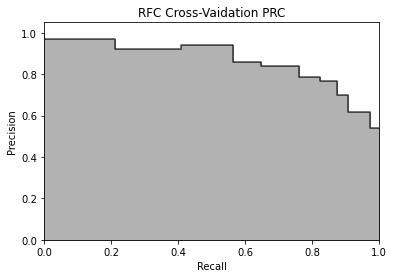

AUCROC = 0.92


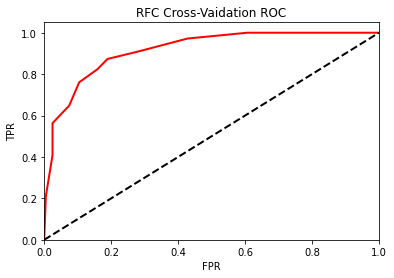

Average Precision = 0.90


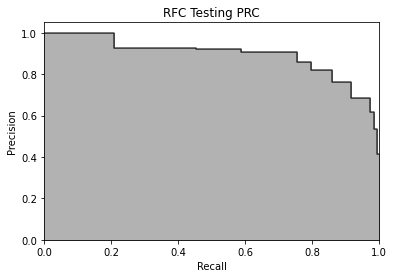

AUCROC = 0.94


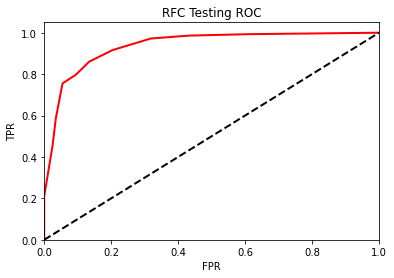

Feature: 0, Score: 0.02743
Feature: 1, Score: 0.09631
Feature: 2, Score: 0.02294
Feature: 3, Score: 0.02334
Feature: 4, Score: 0.01374
Feature: 5, Score: 0.03611
Feature: 6, Score: 0.10293
Feature: 7, Score: 0.00215
Feature: 8, Score: 0.00147
Feature: 9, Score: 0.03821
Feature: 10, Score: 0.06994
Feature: 11, Score: 0.02698
Feature: 12, Score: 0.01460
Feature: 13, Score: 0.02304
Feature: 14, Score: 0.03364
Feature: 15, Score: 0.03954
Feature: 16, Score: 0.01645
Feature: 17, Score: 0.00976
Feature: 18, Score: 0.08688
Feature: 19, Score: 0.17480
Feature: 20, Score: 0.03597
Feature: 21, Score: 0.01236
Feature: 22, Score: 0.00783
Feature: 23, Score: 0.01435
Feature: 24, Score: 0.01138
Feature: 25, Score: 0.03072
Feature: 26, Score: 0.02712


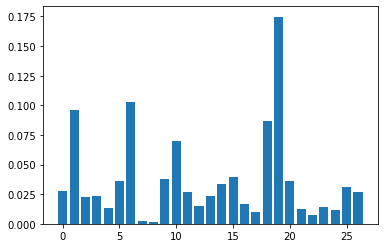

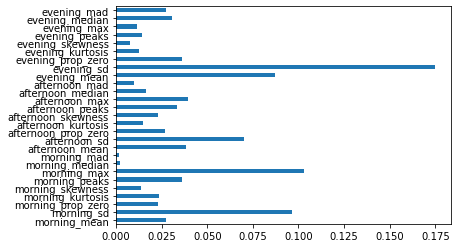

In [47]:
def rfc_train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model

def rfc_pred_func(model, data):
    return model.predict_proba(data)[:, 1]

rfc = RandomForestClassifier( **_PARAMS_RFC )

rfc, rfc_y_preds, rfc_y_trues = model_predict_k_fold( rfc_train_func, rfc_pred_func, rfc )
rfc_test_preds = rfc_pred_func( rfc, X_TEST )


#Leave one out
rfc_loo = RandomForestClassifier(**_PARAMS_RFC)
rfc_loo, rfc_y_preds_loo, rfc_y_trues_loo = leave_one_out( rfc_train_func, rfc_pred_func, rfc_loo )
print(classification_report(rfc_y_trues_loo, rfc_y_preds_loo.round()))

dict_report = classification_report(rfc_y_trues_loo, rfc_y_preds_loo.round(), output_dict=True)
for key, value in dict_report.items():
    row_loo = {"Classifier": "Random Forest" }
    if isinstance(value, dict):
        row_loo["Class"] = get_name_from_value(key)
        row_loo.update(value)

        #collect the result for leave one out
        df_leave_one_out = df_leave_one_out.append(row_loo, ignore_index=True )



average_precision = plot_prc_curve( rfc_y_preds, rfc_y_trues, "RFC Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( rfc_y_preds, rfc_y_trues, "RFC Cross-Vaidation ROC" )

plot_prc_curve( rfc_test_preds, Y_TEST, "RFC Testing PRC" )
plot_roc_curve( rfc_test_preds, Y_TEST, "RFC Testing ROC" )

metric_mattews_coef = matthews_corrcoef(rfc_y_trues, rfc_y_preds.round())


#collect the result
row_stats = {'classifier': "Random Forest", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'Mattews Correlation Coef': metric_mattews_coef,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


# get importance
importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#
(pd.Series(importance, index=X_TRAIN.columns)
   #.nlargest(4)
   .plot(kind='barh'))



series_features = pd.Series(importance, index=X_TRAIN.columns)
row_features = {'classifier': "Random Forest"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)


# Decision Tree



              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86       201
         1.0       0.84      0.73      0.78       142

    accuracy                           0.83       343
   macro avg       0.83      0.82      0.82       343
weighted avg       0.83      0.83      0.83       343

Average Precision = 0.66


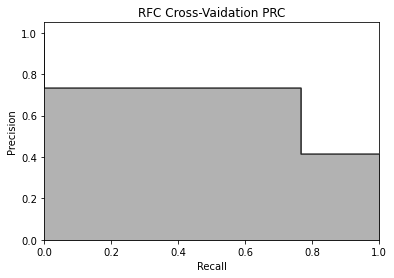

AUCROC = 0.78


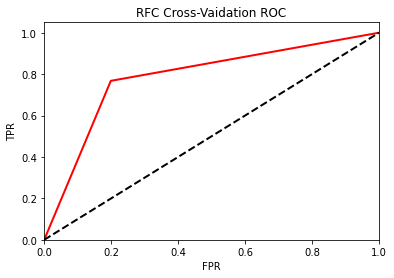

Average Precision = 0.68


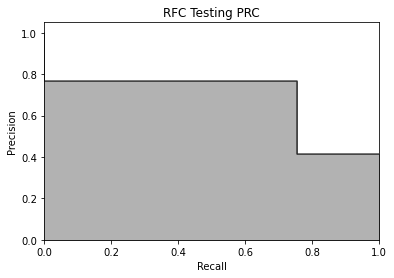

AUCROC = 0.80


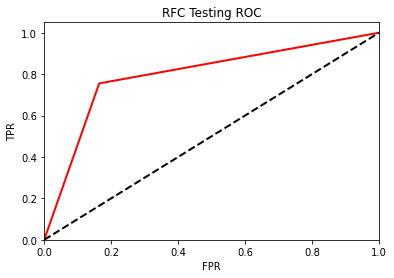

Feature: 0, Score: 0.02743
Feature: 1, Score: 0.09631
Feature: 2, Score: 0.02294
Feature: 3, Score: 0.02334
Feature: 4, Score: 0.01374
Feature: 5, Score: 0.03611
Feature: 6, Score: 0.10293
Feature: 7, Score: 0.00215
Feature: 8, Score: 0.00147
Feature: 9, Score: 0.03821
Feature: 10, Score: 0.06994
Feature: 11, Score: 0.02698
Feature: 12, Score: 0.01460
Feature: 13, Score: 0.02304
Feature: 14, Score: 0.03364
Feature: 15, Score: 0.03954
Feature: 16, Score: 0.01645
Feature: 17, Score: 0.00976
Feature: 18, Score: 0.08688
Feature: 19, Score: 0.17480
Feature: 20, Score: 0.03597
Feature: 21, Score: 0.01236
Feature: 22, Score: 0.00783
Feature: 23, Score: 0.01435
Feature: 24, Score: 0.01138
Feature: 25, Score: 0.03072
Feature: 26, Score: 0.02712


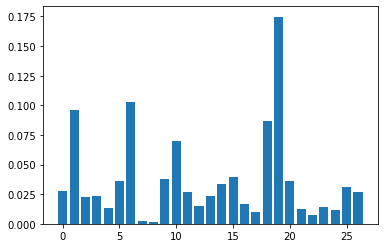

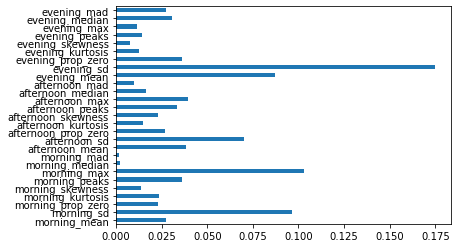

In [48]:
from sklearn.tree import DecisionTreeClassifier

def dtc_train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model

def dtc_pred_func(model, data):
    return model.predict_proba(data)[:, 1]

dtc = DecisionTreeClassifier( **_PARAMS_DTC )

dtc, dtc_y_preds, dtc_y_trues = model_predict_k_fold( dtc_train_func, dtc_pred_func, dtc )
dtc_test_preds = dtc_pred_func( dtc, X_TEST )


#Leave one out
dtc_loo = RandomForestClassifier(**_PARAMS_RFC)
dtc_loo, dtc_y_preds_loo, dtc_y_trues_loo = leave_one_out( dtc_train_func, dtc_pred_func, dtc_loo )
print(classification_report(dtc_y_trues_loo, dtc_y_preds_loo.round()))

dict_report = classification_report(dtc_y_trues_loo, dtc_y_preds_loo.round(), output_dict=True)
for key, value in dict_report.items():
    row_loo = {"Classifier": "Decision Tree" }
    if isinstance(value, dict):
        row_loo["Class"] = get_name_from_value(key)
        row_loo.update(value)

        #collect the result for leave one out
        df_leave_one_out = df_leave_one_out.append(row_loo, ignore_index=True )



average_precision = plot_prc_curve( dtc_y_preds, dtc_y_trues, "RFC Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( dtc_y_preds, dtc_y_trues, "RFC Cross-Vaidation ROC" )

plot_prc_curve( dtc_test_preds, Y_TEST, "RFC Testing PRC" )
plot_roc_curve( dtc_test_preds, Y_TEST, "RFC Testing ROC" )



#collect the result
row_stats = {'classifier': "Decision Tree", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


# get importance
importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#
(pd.Series(importance, index=X_TRAIN.columns)
   #.nlargest(4)
   .plot(kind='barh'))



series_features = pd.Series(importance, index=X_TRAIN.columns)
row_features = {'classifier': "Decision Tree"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)



# XGBoost

[0]	train-logloss:0.50923+0.00476	test-logloss:0.57323+0.00770
[50]	train-logloss:0.02024+0.00080	test-logloss:0.41880+0.07732
[100]	train-logloss:0.01427+0.00031	test-logloss:0.44408+0.08463
[150]	train-logloss:0.01275+0.00023	test-logloss:0.45676+0.08930
[200]	train-logloss:0.01193+0.00034	test-logloss:0.46581+0.09692
[212]	train-logloss:0.01176+0.00036	test-logloss:0.46734+0.09797
[0]	train-logloss:0.50883+0.00466	test-logloss:0.57175+0.01887
[50]	train-logloss:0.02018+0.00110	test-logloss:0.41433+0.17493
[100]	train-logloss:0.01448+0.00056	test-logloss:0.43776+0.19014
[150]	train-logloss:0.01282+0.00031	test-logloss:0.45039+0.19596
[200]	train-logloss:0.01199+0.00037	test-logloss:0.45778+0.19836
[211]	train-logloss:0.01184+0.00039	test-logloss:0.46012+0.20000
[0]	train-logloss:0.50982+0.00285	test-logloss:0.56952+0.02233
[50]	train-logloss:0.02082+0.00044	test-logloss:0.49346+0.11739
[100]	train-logloss:0.01486+0.00041	test-logloss:0.53146+0.12484
[150]	train-logloss:0.01303+0.0002

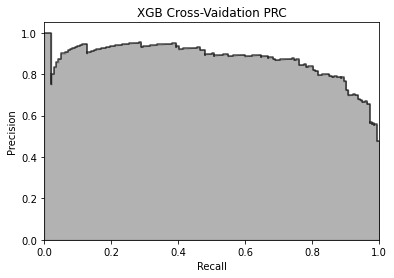

AUCROC = 0.92


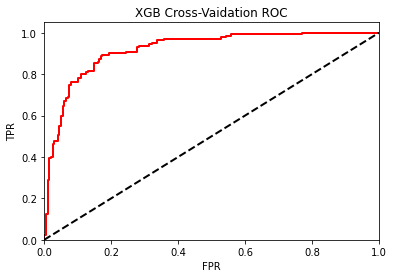

Average Precision = 0.94


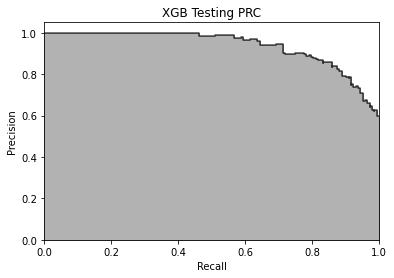

AUCROC = 0.95


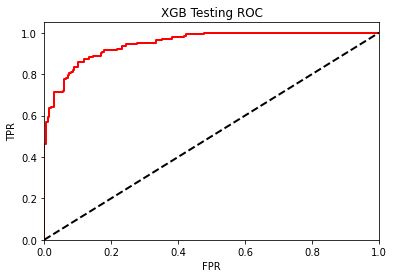

[0]	train-logloss:0.51068+0.00488	test-logloss:0.57225+0.01390
[50]	train-logloss:0.02000+0.00070	test-logloss:0.37026+0.08527
[100]	train-logloss:0.01376+0.00033	test-logloss:0.39325+0.09556
[150]	train-logloss:0.01198+0.00009	test-logloss:0.40869+0.10043
[200]	train-logloss:0.01123+0.00008	test-logloss:0.41524+0.10185
[211]	train-logloss:0.01110+0.00008	test-logloss:0.41679+0.10327
[0]	train-logloss:0.50932+0.00400	test-logloss:0.57324+0.01890
[50]	train-logloss:0.01967+0.00049	test-logloss:0.37817+0.08602
[100]	train-logloss:0.01371+0.00037	test-logloss:0.39885+0.09112
[150]	train-logloss:0.01197+0.00019	test-logloss:0.41488+0.09196
[200]	train-logloss:0.01124+0.00014	test-logloss:0.42146+0.09370
[218]	train-logloss:0.01103+0.00014	test-logloss:0.42323+0.09522
[0]	train-logloss:0.50910+0.00412	test-logloss:0.57487+0.01936
[50]	train-logloss:0.01997+0.00036	test-logloss:0.37531+0.07583
[100]	train-logloss:0.01400+0.00023	test-logloss:0.40018+0.08053
[150]	train-logloss:0.01209+0.0001

[100]	train-logloss:0.01369+0.00021	test-logloss:0.38582+0.09733
[150]	train-logloss:0.01197+0.00011	test-logloss:0.39987+0.10589
[200]	train-logloss:0.01127+0.00010	test-logloss:0.40717+0.10817
[218]	train-logloss:0.01106+0.00010	test-logloss:0.40921+0.10877
[0]	train-logloss:0.51100+0.00371	test-logloss:0.56552+0.02388
[50]	train-logloss:0.02010+0.00020	test-logloss:0.36123+0.08679
[100]	train-logloss:0.01381+0.00024	test-logloss:0.38000+0.08632
[150]	train-logloss:0.01199+0.00022	test-logloss:0.39249+0.09019
[200]	train-logloss:0.01125+0.00017	test-logloss:0.40105+0.09338
[226]	train-logloss:0.01096+0.00016	test-logloss:0.40441+0.09462
[0]	train-logloss:0.51105+0.00362	test-logloss:0.56450+0.02375
[50]	train-logloss:0.01990+0.00010	test-logloss:0.36511+0.07360
[100]	train-logloss:0.01371+0.00018	test-logloss:0.39015+0.08314
[150]	train-logloss:0.01197+0.00014	test-logloss:0.40400+0.08499
[200]	train-logloss:0.01125+0.00011	test-logloss:0.41129+0.08594
[214]	train-logloss:0.01108+0.0

[200]	train-logloss:0.01128+0.00011	test-logloss:0.41417+0.08665
[219]	train-logloss:0.01106+0.00011	test-logloss:0.41743+0.08818
[0]	train-logloss:0.51321+0.00550	test-logloss:0.56982+0.02092
[50]	train-logloss:0.01978+0.00038	test-logloss:0.39397+0.07547
[100]	train-logloss:0.01378+0.00018	test-logloss:0.41523+0.08053
[150]	train-logloss:0.01203+0.00016	test-logloss:0.42941+0.08567
[200]	train-logloss:0.01131+0.00011	test-logloss:0.43582+0.09016
[210]	train-logloss:0.01119+0.00011	test-logloss:0.43733+0.09061
[0]	train-logloss:0.51288+0.00642	test-logloss:0.56967+0.02051
[50]	train-logloss:0.01961+0.00036	test-logloss:0.37093+0.06811
[100]	train-logloss:0.01371+0.00021	test-logloss:0.39304+0.07183
[150]	train-logloss:0.01200+0.00006	test-logloss:0.40943+0.07561
[200]	train-logloss:0.01131+0.00006	test-logloss:0.41718+0.07870
[213]	train-logloss:0.01116+0.00007	test-logloss:0.41953+0.07944
[0]	train-logloss:0.51367+0.00681	test-logloss:0.57002+0.02069
[50]	train-logloss:0.01981+0.0005

[0]	train-logloss:0.51432+0.00450	test-logloss:0.56532+0.01956
[50]	train-logloss:0.01988+0.00040	test-logloss:0.37617+0.07582
[100]	train-logloss:0.01375+0.00015	test-logloss:0.39357+0.07650
[150]	train-logloss:0.01199+0.00013	test-logloss:0.41004+0.07834
[200]	train-logloss:0.01127+0.00012	test-logloss:0.41819+0.08226
[213]	train-logloss:0.01112+0.00012	test-logloss:0.42024+0.08320
[0]	train-logloss:0.51413+0.00421	test-logloss:0.56588+0.01994
[50]	train-logloss:0.01980+0.00048	test-logloss:0.36671+0.07184
[100]	train-logloss:0.01373+0.00009	test-logloss:0.38892+0.07769
[150]	train-logloss:0.01196+0.00015	test-logloss:0.40275+0.07886
[200]	train-logloss:0.01124+0.00013	test-logloss:0.41263+0.08444
[213]	train-logloss:0.01109+0.00013	test-logloss:0.41459+0.08493
[0]	train-logloss:0.51409+0.00419	test-logloss:0.56465+0.01844
[50]	train-logloss:0.01989+0.00017	test-logloss:0.38691+0.06424
[100]	train-logloss:0.01375+0.00007	test-logloss:0.40977+0.07334
[150]	train-logloss:0.01197+0.0000

[100]	train-logloss:0.01381+0.00012	test-logloss:0.37970+0.07265
[150]	train-logloss:0.01203+0.00011	test-logloss:0.39247+0.07584
[200]	train-logloss:0.01127+0.00008	test-logloss:0.39984+0.08013
[210]	train-logloss:0.01115+0.00009	test-logloss:0.40072+0.07946
[0]	train-logloss:0.51165+0.00419	test-logloss:0.55313+0.01591
[50]	train-logloss:0.01935+0.00035	test-logloss:0.35184+0.08032
[100]	train-logloss:0.01362+0.00027	test-logloss:0.36905+0.09088
[150]	train-logloss:0.01189+0.00013	test-logloss:0.37963+0.09104
[200]	train-logloss:0.01116+0.00012	test-logloss:0.38624+0.09234
[217]	train-logloss:0.01096+0.00012	test-logloss:0.38903+0.09281
[0]	train-logloss:0.51397+0.00448	test-logloss:0.55564+0.01700
[50]	train-logloss:0.01966+0.00079	test-logloss:0.36643+0.07487
[100]	train-logloss:0.01381+0.00026	test-logloss:0.38021+0.08368
[150]	train-logloss:0.01197+0.00013	test-logloss:0.39125+0.08698
[200]	train-logloss:0.01125+0.00015	test-logloss:0.39854+0.08913
[210]	train-logloss:0.01113+0.0

[200]	train-logloss:0.01125+0.00009	test-logloss:0.42445+0.09080
[214]	train-logloss:0.01109+0.00009	test-logloss:0.42587+0.09075
[0]	train-logloss:0.51194+0.00257	test-logloss:0.55678+0.02040
[50]	train-logloss:0.01961+0.00065	test-logloss:0.37052+0.06530
[100]	train-logloss:0.01374+0.00032	test-logloss:0.38655+0.07499
[150]	train-logloss:0.01203+0.00012	test-logloss:0.39965+0.07820
[200]	train-logloss:0.01130+0.00012	test-logloss:0.40609+0.07948
[215]	train-logloss:0.01113+0.00012	test-logloss:0.40751+0.07947
[0]	train-logloss:0.51004+0.00339	test-logloss:0.55315+0.02083
[50]	train-logloss:0.01942+0.00063	test-logloss:0.37393+0.08141
[100]	train-logloss:0.01366+0.00033	test-logloss:0.39205+0.08680
[150]	train-logloss:0.01199+0.00015	test-logloss:0.40625+0.08820
[200]	train-logloss:0.01125+0.00016	test-logloss:0.41318+0.08823
[214]	train-logloss:0.01108+0.00017	test-logloss:0.41484+0.08798
[0]	train-logloss:0.51167+0.00385	test-logloss:0.55601+0.02054
[50]	train-logloss:0.01954+0.0006

[0]	train-logloss:0.50835+0.00411	test-logloss:0.56566+0.02737
[50]	train-logloss:0.01976+0.00099	test-logloss:0.37197+0.07854
[100]	train-logloss:0.01390+0.00057	test-logloss:0.38197+0.08460
[150]	train-logloss:0.01205+0.00026	test-logloss:0.39267+0.08375
[200]	train-logloss:0.01127+0.00015	test-logloss:0.39799+0.08631
[217]	train-logloss:0.01107+0.00014	test-logloss:0.39978+0.08635
[0]	train-logloss:0.50848+0.00313	test-logloss:0.56736+0.02895
[50]	train-logloss:0.01976+0.00097	test-logloss:0.38394+0.10510
[100]	train-logloss:0.01370+0.00055	test-logloss:0.39589+0.10811
[150]	train-logloss:0.01189+0.00024	test-logloss:0.40657+0.11024
[200]	train-logloss:0.01115+0.00017	test-logloss:0.41274+0.10937
[216]	train-logloss:0.01097+0.00018	test-logloss:0.41434+0.10910
[0]	train-logloss:0.50895+0.00331	test-logloss:0.56627+0.02796
[50]	train-logloss:0.01990+0.00106	test-logloss:0.37636+0.10930
[100]	train-logloss:0.01383+0.00062	test-logloss:0.39010+0.11581
[150]	train-logloss:0.01207+0.0002

[100]	train-logloss:0.01383+0.00046	test-logloss:0.34822+0.06591
[150]	train-logloss:0.01195+0.00020	test-logloss:0.36037+0.06884
[200]	train-logloss:0.01122+0.00016	test-logloss:0.36633+0.06765
[215]	train-logloss:0.01105+0.00017	test-logloss:0.36878+0.06804
[0]	train-logloss:0.51093+0.00287	test-logloss:0.56453+0.02656
[50]	train-logloss:0.01985+0.00105	test-logloss:0.34965+0.08337
[100]	train-logloss:0.01391+0.00061	test-logloss:0.36780+0.08791
[150]	train-logloss:0.01203+0.00024	test-logloss:0.37831+0.08829
[200]	train-logloss:0.01128+0.00018	test-logloss:0.38437+0.08540
[217]	train-logloss:0.01108+0.00018	test-logloss:0.38621+0.08429
[0]	train-logloss:0.51048+0.00465	test-logloss:0.56283+0.02936
[50]	train-logloss:0.01970+0.00109	test-logloss:0.35623+0.10122
[100]	train-logloss:0.01382+0.00069	test-logloss:0.37501+0.11060
[150]	train-logloss:0.01202+0.00030	test-logloss:0.38677+0.11431
[200]	train-logloss:0.01125+0.00022	test-logloss:0.39397+0.11288
[218]	train-logloss:0.01104+0.0

[200]	train-logloss:0.01131+0.00006	test-logloss:0.39925+0.11343
[215]	train-logloss:0.01113+0.00007	test-logloss:0.40132+0.11365
[0]	train-logloss:0.50801+0.00762	test-logloss:0.57251+0.03670
[50]	train-logloss:0.01990+0.00087	test-logloss:0.37747+0.12786
[100]	train-logloss:0.01392+0.00052	test-logloss:0.39707+0.13441
[150]	train-logloss:0.01205+0.00018	test-logloss:0.41207+0.13630
[200]	train-logloss:0.01130+0.00013	test-logloss:0.41937+0.13536
[214]	train-logloss:0.01114+0.00013	test-logloss:0.42074+0.13436
[0]	train-logloss:0.51139+0.00301	test-logloss:0.55962+0.02391
[50]	train-logloss:0.01977+0.00082	test-logloss:0.36650+0.10509
[100]	train-logloss:0.01387+0.00048	test-logloss:0.38845+0.11477
[150]	train-logloss:0.01207+0.00013	test-logloss:0.40135+0.11435
[200]	train-logloss:0.01131+0.00009	test-logloss:0.40982+0.11424
[216]	train-logloss:0.01113+0.00010	test-logloss:0.41137+0.11341
[0]	train-logloss:0.50943+0.00789	test-logloss:0.56823+0.03618
[50]	train-logloss:0.01947+0.0008

[0]	train-logloss:0.50936+0.00527	test-logloss:0.56268+0.02934
[50]	train-logloss:0.01985+0.00085	test-logloss:0.37239+0.10286
[100]	train-logloss:0.01381+0.00045	test-logloss:0.38856+0.10510
[150]	train-logloss:0.01200+0.00015	test-logloss:0.39737+0.10370
[200]	train-logloss:0.01127+0.00008	test-logloss:0.40311+0.10302
[214]	train-logloss:0.01111+0.00007	test-logloss:0.40472+0.10243
[0]	train-logloss:0.50935+0.00527	test-logloss:0.56270+0.02937
[50]	train-logloss:0.01989+0.00055	test-logloss:0.36261+0.08689
[100]	train-logloss:0.01383+0.00035	test-logloss:0.37412+0.08559
[150]	train-logloss:0.01203+0.00009	test-logloss:0.38273+0.08647
[200]	train-logloss:0.01130+0.00003	test-logloss:0.38904+0.08492
[212]	train-logloss:0.01115+0.00003	test-logloss:0.39102+0.08501
[0]	train-logloss:0.50936+0.00527	test-logloss:0.56268+0.02934
[50]	train-logloss:0.01949+0.00053	test-logloss:0.36764+0.09568
[100]	train-logloss:0.01371+0.00039	test-logloss:0.38006+0.09620
[150]	train-logloss:0.01203+0.0001

[100]	train-logloss:0.01378+0.00044	test-logloss:0.41110+0.09223
[150]	train-logloss:0.01204+0.00018	test-logloss:0.41957+0.09264
[200]	train-logloss:0.01130+0.00013	test-logloss:0.42319+0.09101
[217]	train-logloss:0.01110+0.00013	test-logloss:0.42491+0.09131
[0]	train-logloss:0.51227+0.00137	test-logloss:0.57567+0.02263
[50]	train-logloss:0.01947+0.00077	test-logloss:0.38942+0.06411
[100]	train-logloss:0.01372+0.00043	test-logloss:0.41238+0.07120
[150]	train-logloss:0.01203+0.00020	test-logloss:0.42005+0.07304
[200]	train-logloss:0.01131+0.00013	test-logloss:0.42425+0.07092
[216]	train-logloss:0.01112+0.00012	test-logloss:0.42603+0.07072
[0]	train-logloss:0.51221+0.00170	test-logloss:0.57739+0.02701
[50]	train-logloss:0.01984+0.00076	test-logloss:0.38786+0.06636
[100]	train-logloss:0.01390+0.00043	test-logloss:0.41656+0.07884
[150]	train-logloss:0.01207+0.00019	test-logloss:0.42516+0.08133
[200]	train-logloss:0.01134+0.00013	test-logloss:0.42811+0.08025
[216]	train-logloss:0.01115+0.0

[200]	train-logloss:0.01127+0.00011	test-logloss:0.42802+0.08498
[212]	train-logloss:0.01113+0.00011	test-logloss:0.42801+0.08401
[0]	train-logloss:0.51297+0.00310	test-logloss:0.57314+0.02190
[50]	train-logloss:0.01966+0.00077	test-logloss:0.38337+0.06418
[100]	train-logloss:0.01367+0.00026	test-logloss:0.40538+0.07486
[150]	train-logloss:0.01196+0.00008	test-logloss:0.40976+0.07866
[200]	train-logloss:0.01127+0.00008	test-logloss:0.41308+0.07795
[212]	train-logloss:0.01112+0.00008	test-logloss:0.41418+0.07757
[0]	train-logloss:0.51155+0.00371	test-logloss:0.56710+0.02400
[50]	train-logloss:0.01992+0.00076	test-logloss:0.39054+0.08575
[100]	train-logloss:0.01385+0.00024	test-logloss:0.41110+0.09678
[150]	train-logloss:0.01201+0.00014	test-logloss:0.41876+0.09879
[200]	train-logloss:0.01128+0.00008	test-logloss:0.42284+0.09897
[216]	train-logloss:0.01109+0.00008	test-logloss:0.42446+0.09913
[0]	train-logloss:0.51123+0.00270	test-logloss:0.56799+0.02460
[50]	train-logloss:0.01997+0.0004

[0]	train-logloss:0.51395+0.00438	test-logloss:0.57453+0.02435
[50]	train-logloss:0.01957+0.00063	test-logloss:0.37620+0.06287
[100]	train-logloss:0.01379+0.00029	test-logloss:0.40228+0.07095
[150]	train-logloss:0.01204+0.00018	test-logloss:0.41240+0.06803
[200]	train-logloss:0.01128+0.00014	test-logloss:0.41927+0.06967
[214]	train-logloss:0.01112+0.00015	test-logloss:0.42068+0.06803
[0]	train-logloss:0.51397+0.00436	test-logloss:0.57854+0.02242
[50]	train-logloss:0.01980+0.00053	test-logloss:0.38194+0.06347
[100]	train-logloss:0.01385+0.00036	test-logloss:0.40525+0.07419
[150]	train-logloss:0.01209+0.00017	test-logloss:0.41476+0.07288
[200]	train-logloss:0.01134+0.00013	test-logloss:0.41894+0.07158
[213]	train-logloss:0.01119+0.00014	test-logloss:0.42062+0.07108
[0]	train-logloss:0.51391+0.00438	test-logloss:0.57634+0.02475
[50]	train-logloss:0.01961+0.00044	test-logloss:0.37714+0.04752
[100]	train-logloss:0.01383+0.00027	test-logloss:0.39742+0.05675
[150]	train-logloss:0.01204+0.0001

[100]	train-logloss:0.01362+0.00049	test-logloss:0.41834+0.10036
[150]	train-logloss:0.01193+0.00032	test-logloss:0.42633+0.10042
[200]	train-logloss:0.01121+0.00030	test-logloss:0.43295+0.10227
[210]	train-logloss:0.01109+0.00030	test-logloss:0.43352+0.10270
[0]	train-logloss:0.51245+0.00509	test-logloss:0.57088+0.03135
[50]	train-logloss:0.01935+0.00097	test-logloss:0.37662+0.07297
[100]	train-logloss:0.01365+0.00057	test-logloss:0.39356+0.08439
[150]	train-logloss:0.01198+0.00037	test-logloss:0.40011+0.08459
[200]	train-logloss:0.01123+0.00035	test-logloss:0.40402+0.08360
[216]	train-logloss:0.01104+0.00035	test-logloss:0.40523+0.08586
[0]	train-logloss:0.51277+0.00516	test-logloss:0.57126+0.02470
[50]	train-logloss:0.01968+0.00109	test-logloss:0.38167+0.09347
[100]	train-logloss:0.01383+0.00055	test-logloss:0.40727+0.10754
[150]	train-logloss:0.01207+0.00033	test-logloss:0.41595+0.11058
[200]	train-logloss:0.01130+0.00029	test-logloss:0.42188+0.11245
[216]	train-logloss:0.01111+0.0

[200]	train-logloss:0.01121+0.00025	test-logloss:0.42218+0.09165
[216]	train-logloss:0.01102+0.00026	test-logloss:0.42352+0.09187
[0]	train-logloss:0.51157+0.00480	test-logloss:0.57523+0.01657
[50]	train-logloss:0.01969+0.00101	test-logloss:0.38804+0.09492
[100]	train-logloss:0.01377+0.00050	test-logloss:0.40865+0.10891
[150]	train-logloss:0.01196+0.00025	test-logloss:0.42357+0.11197
[200]	train-logloss:0.01122+0.00024	test-logloss:0.43072+0.11297
[217]	train-logloss:0.01102+0.00024	test-logloss:0.43286+0.11327
[0]	train-logloss:0.51096+0.00357	test-logloss:0.57294+0.01656
[50]	train-logloss:0.01989+0.00102	test-logloss:0.38059+0.07258
[100]	train-logloss:0.01389+0.00052	test-logloss:0.39948+0.08243
[150]	train-logloss:0.01207+0.00026	test-logloss:0.41355+0.08471
[200]	train-logloss:0.01128+0.00023	test-logloss:0.41942+0.08508
[211]	train-logloss:0.01115+0.00023	test-logloss:0.42155+0.08627
[0]	train-logloss:0.51075+0.00382	test-logloss:0.57263+0.01693
[50]	train-logloss:0.01977+0.0009

[0]	train-logloss:0.51007+0.00535	test-logloss:0.56853+0.02361
[50]	train-logloss:0.01968+0.00103	test-logloss:0.40227+0.08216
[100]	train-logloss:0.01369+0.00057	test-logloss:0.42630+0.09777
[150]	train-logloss:0.01199+0.00031	test-logloss:0.43885+0.10043
[200]	train-logloss:0.01122+0.00029	test-logloss:0.44455+0.10240
[213]	train-logloss:0.01106+0.00030	test-logloss:0.44720+0.10470
[0]	train-logloss:0.50947+0.00567	test-logloss:0.57143+0.02268
[50]	train-logloss:0.01959+0.00090	test-logloss:0.39923+0.10288
[100]	train-logloss:0.01376+0.00055	test-logloss:0.41880+0.10964
[150]	train-logloss:0.01196+0.00029	test-logloss:0.43002+0.11096
[200]	train-logloss:0.01122+0.00031	test-logloss:0.43504+0.11358
[218]	train-logloss:0.01100+0.00032	test-logloss:0.43786+0.11512
[0]	train-logloss:0.50974+0.00549	test-logloss:0.57096+0.02221
[50]	train-logloss:0.01951+0.00118	test-logloss:0.38658+0.11267
[100]	train-logloss:0.01380+0.00060	test-logloss:0.40844+0.11634
[150]	train-logloss:0.01205+0.0002

[100]	train-logloss:0.01370+0.00066	test-logloss:0.45482+0.09451
[150]	train-logloss:0.01198+0.00034	test-logloss:0.46881+0.08872
[200]	train-logloss:0.01123+0.00028	test-logloss:0.47551+0.09090
[211]	train-logloss:0.01110+0.00028	test-logloss:0.47655+0.09169
[0]	train-logloss:0.50828+0.00550	test-logloss:0.57420+0.02289
[50]	train-logloss:0.01966+0.00082	test-logloss:0.40679+0.10467
[100]	train-logloss:0.01378+0.00058	test-logloss:0.42880+0.10754
[150]	train-logloss:0.01209+0.00030	test-logloss:0.44134+0.10474
[200]	train-logloss:0.01131+0.00026	test-logloss:0.44804+0.10583
[213]	train-logloss:0.01116+0.00027	test-logloss:0.44962+0.10622
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.88       201
         1.0       0.83      0.85      0.84       142

    accuracy                           0.86       343
   macro avg       0.86      0.86      0.86       343
weighted avg       0.86      0.86      0.86       343



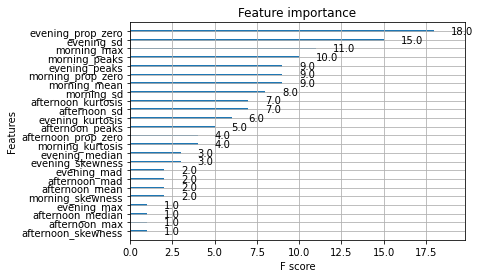

In [49]:
def xgb_train_func(model, x_train, y_train, x_test, y_test):
    dtrain = xgb.DMatrix(data=x_train, label=y_train)

    bst = xgb.cv(_PARAMS_XGB,
        dtrain,
        num_boost_round=2000,
        nfold=5,
        early_stopping_rounds=200,
        verbose_eval=50
    )

    best_rounds = np.argmin(bst["test-logloss-mean"])
    bst = xgb.train(_PARAMS_XGB, dtrain, best_rounds)
    return bst

def xgb_pred_func(model, data):
    data = xgb.DMatrix(data=data)
    pred = model.predict(data)
    return pred

xgb_model, xgb_y_preds, xgb_y_trues = model_predict_k_fold( xgb_train_func, xgb_pred_func )
xgb_test_preds = xgb_pred_func( xgb_model, X_TEST )

average_precision = plot_prc_curve( xgb_y_preds, xgb_y_trues, "XGB Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( xgb_y_preds, xgb_y_trues, "XGB Cross-Vaidation ROC" )

plot_prc_curve( xgb_test_preds, Y_TEST, "XGB Testing PRC" )
plot_roc_curve( xgb_test_preds, Y_TEST, "XGB Testing ROC" )



#Leave one out

xgb_loo, xgb_y_preds_loo, xgb_y_trues_loo = leave_one_out( xgb_train_func, xgb_pred_func )
print(classification_report(xgb_y_trues_loo, xgb_y_preds_loo.round()))

dict_report = classification_report(xgb_y_trues_loo, xgb_y_preds_loo.round(), output_dict=True)
for key, value in dict_report.items():
    row_loo = {"Classifier": "XGBoost" }
    if isinstance(value, dict):
        row_loo["Class"] = get_name_from_value(key)
        row_loo.update(value)

        #collect the result for leave one out
        df_leave_one_out = df_leave_one_out.append(row_loo, ignore_index=True )

metric_mattews_coef = matthews_corrcoef(rfc_y_trues, rfc_y_preds.round())

#collect the result
row_stats = {'classifier': "XGBoot", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


# plot feature importance
plot_importance(xgb_model)
pyplot.show()



series_features = pd.Series(importance, index=X_TRAIN.columns)
row_features = {'classifier': "XGBoost"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)



# LightGBM

Average Precision = 0.93


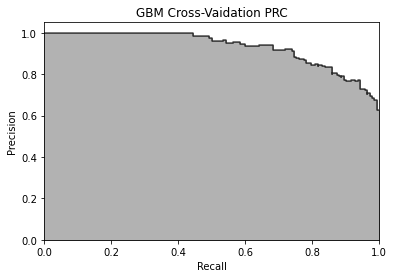

AUCROC = 0.95


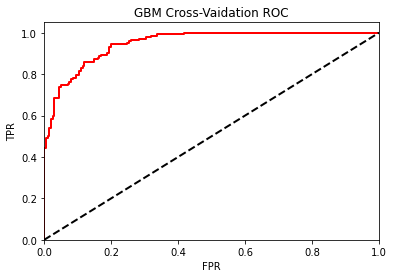

Average Precision = 0.96


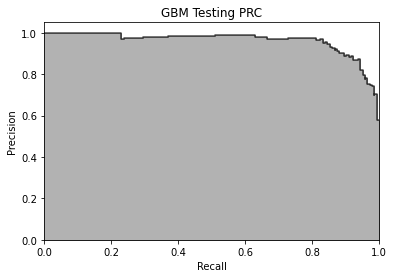

AUCROC = 0.97


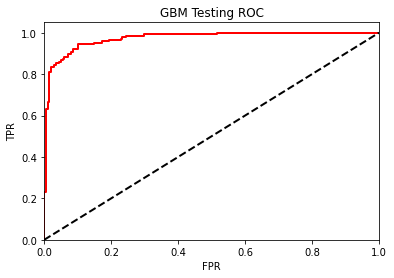

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       201
         1.0       1.00      0.83      0.91       142

    accuracy                           0.93       343
   macro avg       0.95      0.92      0.93       343
weighted avg       0.94      0.93      0.93       343

Plotting feature importances...


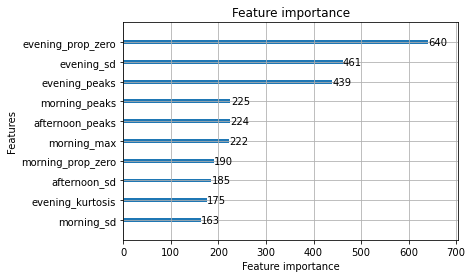

In [50]:
def gbm_train_func(model, x_train, y_train, x_test, y_test):
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

    gbm = lgb.train(
        _PARAMS_LIGHTGB,
        lgb_train,
        verbose_eval=False,
        num_boost_round=2000,
        valid_sets=lgb_eval,
        early_stopping_rounds=200
    )

    return gbm

def gbm_pred_func(model, data):
    return model.predict(data, num_iteration=model.best_iteration)

gbm, gbm_y_preds, gbm_y_trues = model_predict_k_fold( gbm_train_func, gbm_pred_func )
gbm_test_preds = gbm_pred_func( gbm, X_TEST )

average_precision = plot_prc_curve( gbm_y_preds, gbm_y_trues, "GBM Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( gbm_y_preds, gbm_y_trues, "GBM Cross-Vaidation ROC" )

plot_prc_curve( gbm_test_preds, Y_TEST, "GBM Testing PRC" )
plot_roc_curve( gbm_test_preds, Y_TEST, "GBM Testing ROC" )


#Leave one out

lgbm_loo, lgbm_y_preds_loo, lgbm_y_trues_loo = leave_one_out( gbm_train_func, gbm_pred_func )
print(classification_report(lgbm_y_trues_loo, lgbm_y_preds_loo.round()))

dict_report = classification_report(lgbm_y_trues_loo, lgbm_y_preds_loo.round(), output_dict=True)
for key, value in dict_report.items():
    row_loo = {"Classifier": "LightGBM" }
    if isinstance(value, dict):
        row_loo["Class"] = get_name_from_value(key)
        row_loo.update(value)

        #collect the result for leave one out
        df_leave_one_out = df_leave_one_out.append(row_loo, ignore_index=True )

#collect the result
row_stats = {'classifier': "LightGBM", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()



df_feature_importance_2 = (
    pd.DataFrame({
        'feature': gbm.feature_name(),
        'importance': gbm.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)

series_features = pd.Series(gbm.feature_importance(), index=gbm.feature_name())
row_features = {'classifier': "LightGBM"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)



# Ensemble

Average Precision = 0.93


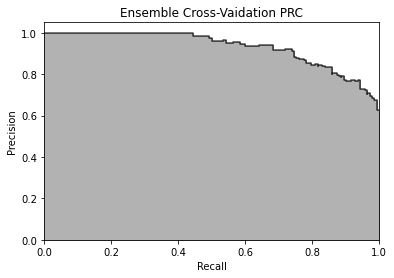

AUCROC = 0.95


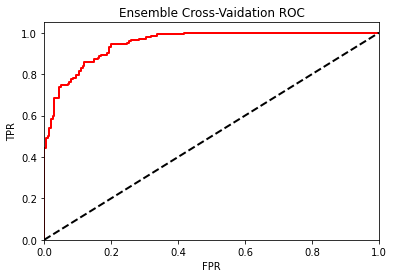

Average Precision = 0.96


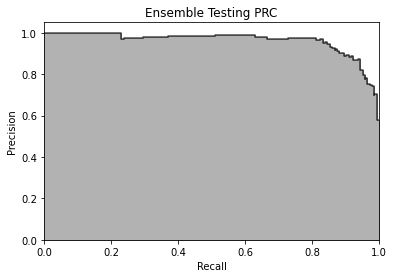

AUCROC = 0.97


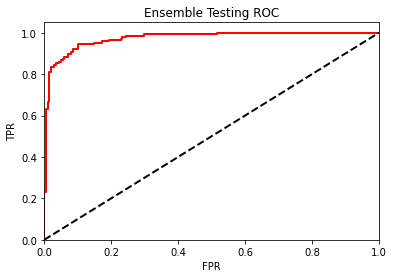

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       201
         1.0       1.00      0.83      0.91       142

    accuracy                           0.93       343
   macro avg       0.95      0.92      0.93       343
weighted avg       0.94      0.93      0.93       343

Plotting feature importances...


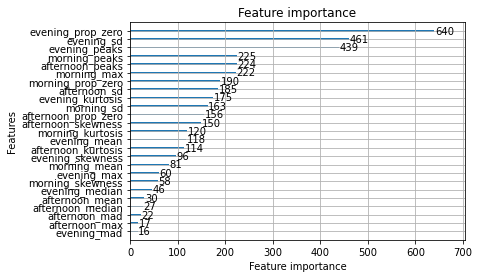

In [51]:
def ensemble_train_func(model, x_train, y_train, x_test, y_test):
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

    ensemble = lgb.train(
        _PARAMS_LIGHTGB,
        lgb_train,
        verbose_eval=False,
        num_boost_round=2000,
        valid_sets=lgb_eval,
        early_stopping_rounds=200
    )

    return ensemble

def ensemble_pred_func(model, data):
    return model.predict(data, num_iteration=model.best_iteration)

ensemble, ensemble_y_preds, ensemble_y_trues = model_predict_k_fold( ensemble_train_func, ensemble_pred_func )
ensemble_test_preds = ensemble_pred_func( ensemble, X_TEST )

average_precision = plot_prc_curve( ensemble_y_preds, ensemble_y_trues, "Ensemble Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( ensemble_y_preds, ensemble_y_trues, "Ensemble Cross-Vaidation ROC" )

plot_prc_curve( ensemble_test_preds, Y_TEST, "Ensemble Testing PRC" )
plot_roc_curve( ensemble_test_preds, Y_TEST, "Ensemble Testing ROC" )


#Leave one out

ensemble_loo, ensemble_y_preds_loo, ensemble_y_trues_loo = leave_one_out( ensemble_train_func, ensemble_pred_func )
print(classification_report(ensemble_y_trues_loo, ensemble_y_preds_loo.round()))

dict_report = classification_report(ensemble_y_trues_loo, ensemble_y_preds_loo.round(), output_dict=True)
for key, value in dict_report.items():
    row_loo = {"Classifier": "Ensemble" }
    if isinstance(value, dict):
        row_loo["Class"] = get_name_from_value(key)
        row_loo.update(value)

        #collect the result for leave one out
        df_leave_one_out = df_leave_one_out.append(row_loo, ignore_index=True )


#collect the result
row_stats = {'classifier': "Ensemble", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )



print('Plotting feature importances...')
ax = lgb.plot_importance(ensemble)
plt.show()




series_features = pd.Series(ensemble.feature_importance(), index=ensemble.feature_name())
row_features = {'classifier': "Ensemble"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)


In [14]:
df_result = df_result[['classifier', 'Average Precision', 'AUCROC', 'testset_size']]
df_result


,classifier,Average Precision,AUCROC,testset_size
0,Logistic Regression,0.914541,0.937355,0.5
1,Random Forest,0.859989,0.913005,0.5
2,XGBoot,0.928329,0.942085,0.5
3,LightGBM,0.949978,0.959183,0.5
4,Ensemble,0.949978,0.959183,0.5


In [15]:
#df_feature_importance = df_feature_importance[['classifier', 'mean', 'sd', 'prop_zero', 'kurtosis', 'skew']]
#df_feature_importance = df_feature_importance[['classifier', 'mean', 'sd', 'prop_zero']]
df_feature_importance

,afternoon_kurtosis,afternoon_mean,afternoon_prop_zero,afternoon_sd,afternoon_skewness,classifier,evening_kurtosis,evening_mean,evening_prop_zero,evening_sd,evening_skewness,morning_kurtosis,morning_mean,morning_prop_zero,morning_sd,morning_skewness
0,0.984722,0.648944,0.411228,-1.614072,-0.149704,Logistic Regression,-0.225387,0.815214,1.485514,-1.398185,-0.029793,0.112705,0.736065,-0.142280,-1.779904,0.020729
1,0.048393,0.097586,0.059082,0.139650,0.037515,Random Forest,0.043697,0.089672,0.128365,0.135714,0.020860,0.031206,0.036105,0.053069,0.052303,0.026784
2,0.048393,0.097586,0.059082,0.139650,0.037515,XGBoost,0.043697,0.089672,0.128365,0.135714,0.020860,0.031206,0.036105,0.053069,0.052303,0.026784
3,202.000000,72.000000,285.000000,367.000000,55.000000,LightGBM,112.000000,126.000000,628.000000,546.000000,224.000000,103.000000,103.000000,432.000000,427.000000,249.000000
4,202.000000,72.000000,285.000000,367.000000,55.000000,Ensemble,112.000000,126.000000,628.000000,546.000000,224.000000,103.000000,103.000000,432.000000,427.000000,249.000000


In [40]:
df_leave_one_out = df_leave_one_out[['Classifier', 'Class', 'precision', 'recall', 'f1-score', 'support']]
df_leave_one_out

,Classifier,Class,precision,recall,f1-score,support
0,Logistic Regression,CONTROL,0.936508,0.880597,0.907692,201.0
1,Logistic Regression,PATIENT,0.844156,0.915493,0.878378,142.0
2,Logistic Regression,macro avg,0.890332,0.898045,0.893035,343.0
3,Logistic Regression,weighted avg,0.898275,0.895044,0.895557,343.0
4,Random Forest,CONTROL,0.841121,0.895522,0.867470,201.0
5,Random Forest,PATIENT,0.837209,0.760563,0.797048,142.0
6,Random Forest,macro avg,0.839165,0.828043,0.832259,343.0
7,Random Forest,weighted avg,0.839502,0.839650,0.838316,343.0
8,Decision Tree,CONTROL,0.841121,0.895522,0.867470,201.0
9,Decision Tree,PATIENT,0.837209,0.760563,0.797048,142.0


In [ ]:
#with number of peaks for each period of time 

In [12]:
#k-fold validation
df_result = df_result[['classifier', 'Average Precision', 'AUCROC', 'testset_size']]
df_result

,classifier,Average Precision,AUCROC,testset_size
0,Logistic Regression,0.932656,0.953192,0.5
1,Random Forest,0.845964,0.912778,0.5
2,Decision Tree,0.639739,0.766695,0.5
3,XGBoot,0.897204,0.941420,0.5
4,LightGBM,0.936629,0.953052,0.5
5,Ensemble,0.936629,0.953052,0.5


In [13]:
#leave one-out
df_leave_one_out = df_leave_one_out[['Classifier', 'Class', 'precision', 'recall', 'f1-score', 'support']]
df_leave_one_out

,Classifier,Class,precision,recall,f1-score,support
0,Logistic Regression,CONTROL,0.921875,0.880597,0.900763,201.0
1,Logistic Regression,PATIENT,0.841060,0.894366,0.866894,142.0
2,Logistic Regression,macro avg,0.881467,0.887482,0.883829,343.0
3,Logistic Regression,weighted avg,0.888418,0.886297,0.886742,343.0
4,Random Forest,CONTROL,0.841121,0.895522,0.867470,201.0
5,Random Forest,PATIENT,0.837209,0.760563,0.797048,142.0
6,Random Forest,macro avg,0.839165,0.828043,0.832259,343.0
7,Random Forest,weighted avg,0.839502,0.839650,0.838316,343.0
8,Decision Tree,CONTROL,0.841121,0.895522,0.867470,201.0
9,Decision Tree,PATIENT,0.837209,0.760563,0.797048,142.0


In [ ]:
#with number of peaks and max value

In [13]:
#k-fold validation
df_result = df_result[['classifier', 'Average Precision', 'AUCROC', 'testset_size']]
df_result

,classifier,Average Precision,AUCROC,testset_size
0,Logistic Regression,0.904482,0.940754,0.5
1,Random Forest,0.888598,0.932223,0.5
2,Decision Tree,0.695868,0.814344,0.5
3,XGBoot,0.939431,0.956100,0.5
4,LightGBM,0.968666,0.973863,0.5
5,Ensemble,0.968666,0.973863,0.5


In [12]:
#leave one-out
df_leave_one_out = df_leave_one_out[['Classifier', 'Class', 'precision', 'recall', 'f1-score', 'support']]
df_leave_one_out

,Classifier,Class,precision,recall,f1-score,support
0,Logistic Regression,CONTROL,0.931579,0.880597,0.905371,201.0
1,Logistic Regression,PATIENT,0.843137,0.908451,0.874576,142.0
2,Logistic Regression,macro avg,0.887358,0.894524,0.889974,343.0
3,Logistic Regression,weighted avg,0.894965,0.892128,0.892622,343.0
4,Random Forest,CONTROL,0.856481,0.920398,0.887290,201.0
5,Random Forest,PATIENT,0.874016,0.781690,0.825279,142.0
6,Random Forest,macro avg,0.865249,0.851044,0.856284,343.0
7,Random Forest,weighted avg,0.863741,0.862974,0.861618,343.0
8,Decision Tree,CONTROL,0.856481,0.920398,0.887290,201.0
9,Decision Tree,PATIENT,0.874016,0.781690,0.825279,142.0


In [ ]:
#all features
#including median and median absolute deviation

In [52]:
#k-fold validation
df_result = df_result[['classifier', 'Average Precision', 'AUCROC', 'testset_size']]
df_result

,classifier,Average Precision,AUCROC,testset_size
0,Logistic Regression,0.918371,0.940439,0.5
1,Random Forest,0.865048,0.916246,0.5
2,Decision Tree,0.657747,0.784300,0.5
3,XGBoot,0.872713,0.919872,0.5
4,LightGBM,0.932128,0.949093,0.5
5,Ensemble,0.932128,0.949093,0.5


In [9]:
k_fold_sorted_df = df_result.sort_values(by=['Average Precision', 'AUCROC'], ascending=False)
k_fold_sorted_df

,classifier,Average Precision,AUCROC,Mattews Correlation Coef,testset_size
0,Logistic Regression,0.918371,0.940439,0.762491,0.5


In [53]:
#leave one-out
df_leave_one_out = df_leave_one_out[['Classifier', 'Class', 'precision', 'recall', 'f1-score', 'support']]
df_leave_one_out

,Classifier,Class,precision,recall,f1-score,support
0,Logistic Regression,CONTROL,0.922280,0.885572,0.903553,201.0
1,Logistic Regression,PATIENT,0.846667,0.894366,0.869863,142.0
2,Logistic Regression,macro avg,0.884473,0.889969,0.886708,343.0
3,Logistic Regression,weighted avg,0.890976,0.889213,0.889606,343.0
4,Random Forest,CONTROL,0.826484,0.900498,0.861905,201.0
5,Random Forest,PATIENT,0.838710,0.732394,0.781955,142.0
6,Random Forest,macro avg,0.832597,0.816446,0.821930,343.0
7,Random Forest,weighted avg,0.831545,0.830904,0.828806,343.0
8,Decision Tree,CONTROL,0.826484,0.900498,0.861905,201.0
9,Decision Tree,PATIENT,0.838710,0.732394,0.781955,142.0


In [56]:
#filter weighted avg

df_loo_filter = df_leave_one_out[df_leave_one_out['Class']=='weighted avg']
df_loo_filter

,Classifier,Class,precision,recall,f1-score,support
3,Logistic Regression,weighted avg,0.890976,0.889213,0.889606,343.0
7,Random Forest,weighted avg,0.831545,0.830904,0.828806,343.0
11,Decision Tree,weighted avg,0.831545,0.830904,0.828806,343.0
15,XGBoost,weighted avg,0.863510,0.862974,0.863175,343.0
19,LightGBM,weighted avg,0.937493,0.930029,0.928771,343.0
23,Ensemble,weighted avg,0.937493,0.930029,0.928771,343.0


In [60]:
#sort by precision
loo_sorted_df = df_loo_filter.sort_values(by=['precision'], ascending=False)
loo_sorted_df

,Classifier,Class,precision,recall,f1-score,support
19,LightGBM,weighted avg,0.937493,0.930029,0.928771,343.0
23,Ensemble,weighted avg,0.937493,0.930029,0.928771,343.0
3,Logistic Regression,weighted avg,0.890976,0.889213,0.889606,343.0
15,XGBoost,weighted avg,0.863510,0.862974,0.863175,343.0
7,Random Forest,weighted avg,0.831545,0.830904,0.828806,343.0
11,Decision Tree,weighted avg,0.831545,0.830904,0.828806,343.0
